In [60]:
import pandas as pd
import numpy as np
import pypsa
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/poweruser/Desktop/pypsa-new/pypsa-eur-sec/scripts')


import pypsa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.legend_handler import HandlerPatch
from matplotlib.patches import Circle, Ellipse

#from . import make_summary
from scripts.make_summary import assign_carriers
from plot_summary import rename_techs, preferred_order
from helper import override_component_attrs
#import plot_network
import plotly

ModuleNotFoundError: No module named 'plotly'

In [32]:
import pypsa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.legend_handler import HandlerPatch
from matplotlib.patches import Circle, Ellipse

from make_summary import assign_carriers
from plot_summary import rename_techs, preferred_order
from helper import override_component_attrs

plt.style.use('ggplot')

OUTDIR = "results/analysis/"

def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    elif tech in ["H2 Electrolysis", "methanation", "helmeth", "H2 liquefaction"]:
        return "power-to-gas"
    elif tech == "H2":
        return "H2 storage"
    elif tech in ["OCGT", "CHP", "gas boiler", "H2 Fuel Cell"]:
        return "gas-to-power/heat"
    elif "solar" in tech:
        return "solar"
    elif tech == "Fischer-Tropsch":
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    elif "CC" in tech or "sequestration" in tech:
        return "CCS"
    else:
        return tech


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (72. / fig.dpi)

    ellipses = []
    if not dont_resize_actively:
        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2. * radius * dist
        fig.canvas.mpl_connect('resize_event', update_width_height)
        ax.callbacks.connect('xlim_changed', update_width_height)
        ax.callbacks.connect('ylim_changed', update_width_height)

    def legend_circle_handler(legend, orig_handle, xdescent, ydescent,
                              width, height, fontsize):
        w, h = 2. * orig_handle.get_radius() * axes2pt()
        e = Ellipse(xy=(0.5 * width - 0.5 * xdescent, 0.5 *
                        height - 0.5 * ydescent), width=w, height=w)
        ellipses.append((e, orig_handle.get_radius()))
        return e
    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale)**0.5, **kw) for s in sizes]


def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1: continue
            names = ifind.index[ifind == i]
            c.df.loc[names, 'location'] = names.str[:i]


def plot_map(network, components=["links", "stores", "storage_units", "generators"],
             bus_size_factor=1.7e10, transmission=False):

    n = network.copy()
    assign_location(n)
    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)

    costs = pd.DataFrame(index=n.buses.index)

    for comp in components:
        df_c = getattr(n, comp)
        df_c["nice_group"] = df_c.carrier.map(rename_techs_tyndp)

        attr = "e_nom_opt" if comp == "stores" else "p_nom_opt"

        costs_c = ((df_c['capital_cost'] * df_c[attr])
                   .groupby([df_c.location, df_c.nice_group]).sum()
                   .unstack().fillna(0.))
        costs = pd.concat([costs, costs_c], axis=1)

        print(comp, costs)

    costs = costs.groupby(costs.columns, axis=1).sum()

    costs.drop(list(costs.columns[(costs == 0.).all()]), axis=1, inplace=True)

    new_columns = (preferred_order.intersection(costs.columns)
                   .append(costs.columns.difference(preferred_order)))
    costs = costs[new_columns]

    for item in new_columns:
        if item not in snakemake.config['plotting']['tech_colors']:
            print("Warning!",item,"not in config/plotting/tech_colors")

    costs = costs.stack()  # .sort_index()

    # hack because impossible to drop buses...
    eu_location = snakemake.config["plotting"].get("eu_node_location", dict(x=-5.5, y=46))
    n.buses.loc["EU gas", "x"] = eu_location["x"]
    n.buses.loc["EU gas", "y"] = eu_location["y"]

    n.links.drop(n.links.index[(n.links.carrier != "DC") & (
        n.links.carrier != "B2B")], inplace=True)

    # drop non-bus
    to_drop = costs.index.levels[0].symmetric_difference(n.buses.index)
    if len(to_drop) != 0:
        print("dropping non-buses", to_drop)
        costs.drop(to_drop, level=0, inplace=True, axis=0, errors="ignore")

    # make sure they are removed from index
    costs.index = pd.MultiIndex.from_tuples(costs.index.values)

    # PDF has minimum width, so set these to zero
    line_lower_threshold = 500.
    line_upper_threshold = 1e4
    linewidth_factor = 2e3
    ac_color = "gray"
    dc_color = "m"

    if snakemake.wildcards["lv"] == "1.0":
        # should be zero
        line_widths = n.lines.s_nom_opt - n.lines.s_nom
        link_widths = n.links.p_nom_opt - n.links.p_nom
        title = "Transmission reinforcement"

        if transmission:
            line_widths = n.lines.s_nom_opt
            link_widths = n.links.p_nom_opt
            linewidth_factor = 2e3
            line_lower_threshold = 0.
            title = "Today's transmission"
    else:
        line_widths = n.lines.s_nom_opt - n.lines.s_nom_min
        link_widths = n.links.p_nom_opt - n.links.p_nom_min
        title = "Transmission reinforcement"

        if transmission:
            line_widths = n.lines.s_nom_opt
            link_widths = n.links.p_nom_opt
            title = "Total transmission"

    line_widths[line_widths < line_lower_threshold] = 0.
    link_widths[link_widths < line_lower_threshold] = 0.

    line_widths[line_widths > line_upper_threshold] = line_upper_threshold
    link_widths[link_widths > line_upper_threshold] = line_upper_threshold

    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
    fig.set_size_inches(7, 6)

    n.plot(
        bus_sizes=costs / bus_size_factor,
        bus_colors=snakemake.config['plotting']['tech_colors'],
        line_colors=ac_color,
        link_colors=dc_color,
        line_widths=line_widths / linewidth_factor,
        link_widths=link_widths / linewidth_factor,
        ax=ax,  **map_opts
    )

    handles = make_legend_circles_for(
        [5e9, 1e9],
        scale=bus_size_factor,
        facecolor="gray"
    )

    labels = ["{} bEUR/a".format(s) for s in (5, 1)]

    l2 = ax.legend(
        handles, labels,
        loc="upper left",
        bbox_to_anchor=(0.01, 1.01),
        labelspacing=1.0,
        frameon=False,
        title='System cost',
        handler_map=make_handler_map_to_scale_circles_as_in(ax)
    )

    ax.add_artist(l2)

    handles = []
    labels = []

    for s in (10, 5):
        handles.append(plt.Line2D([0], [0], color=ac_color,
                                  linewidth=s * 1e3 / linewidth_factor))
        labels.append("{} GW".format(s))

    l1_1 = ax.legend(
        handles, labels,
        loc="upper left",
        bbox_to_anchor=(0.22, 1.01),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title=title
    )

    ax.add_artist(l1_1)

    fig.savefig(
        OUTDIR+"map.png",
        transparent=True,
        bbox_inches="tight"
    )

def group_pipes(df, drop_direction=False):
    """Group pipes which connect same buses and return overall capacity.
    """
    if drop_direction:
        positive_order = df.bus0 < df.bus1
        df_p = df[positive_order]
        swap_buses = {"bus0": "bus1", "bus1": "bus0"}
        df_n = df[~positive_order].rename(columns=swap_buses)
        df = pd.concat([df_p, df_n])

    # there are pipes for each investment period rename to AC buses name for plotting
    df.index = df.apply(
        lambda x: f"H2 pipeline {x.bus0.replace(' H2', '')} -> {x.bus1.replace(' H2', '')}",
        axis=1
    )
    # group pipe lines connecting the same buses and rename them for plotting
    pipe_capacity = df["p_nom_opt"].groupby(level=0).sum()

    return pipe_capacity


def plot_h2_map(network):

    n = network.copy()
    if "H2 pipeline" not in n.links.carrier.unique():
        return

    assign_location(n)

    bus_size_factor = 1e5
    linewidth_factor = 1e4
    # MW below which not drawn
    line_lower_threshold = 1e2

    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)

    elec = n.links[n.links.carrier.isin(["H2 Electrolysis", "H2 Fuel Cell"])].index

    bus_sizes = n.links.loc[elec,"p_nom_opt"].groupby([n.links["bus0"], n.links.carrier]).sum() / bus_size_factor

    # make a fake MultiIndex so that area is correct for legend
    bus_sizes.rename(index=lambda x: x.replace(" H2", ""), level=0, inplace=True)
    # drop all links which are not H2 pipelines
    n.links.drop(n.links.index[~n.links.carrier.str.contains("H2 pipeline")], inplace=True)

    h2_new = n.links.loc[n.links.carrier=="H2 pipeline"]
    h2_retro = n.links.loc[n.links.carrier=='H2 pipeline retrofitted']
    # sum capacitiy for pipelines from different investment periods
    h2_new = group_pipes(h2_new)
    h2_retro = group_pipes(h2_retro, drop_direction=True).reindex(h2_new.index).fillna(0)


    n.links.rename(index=lambda x: x.split("-2")[0], inplace=True)
    n.links = n.links.groupby(level=0).first()
    link_widths_total = (h2_new + h2_retro) / linewidth_factor
    link_widths_total = link_widths_total.reindex(n.links.index).fillna(0.)
    link_widths_total[n.links.p_nom_opt < line_lower_threshold] = 0.

    retro = n.links.p_nom_opt.where(n.links.carrier=='H2 pipeline retrofitted', other=0.)
    link_widths_retro = retro / linewidth_factor
    link_widths_retro[n.links.p_nom_opt < line_lower_threshold] = 0.

    n.links.bus0 = n.links.bus0.str.replace(" H2", "")
    n.links.bus1 = n.links.bus1.str.replace(" H2", "")

    fig, ax = plt.subplots(
        figsize=(7, 6),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        bus_sizes=bus_sizes,
        bus_colors=snakemake.config['plotting']['tech_colors'],
        link_colors='#a2f0f2',
        link_widths=link_widths_total,
        branch_components=["Link"],
        ax=ax,
        **map_opts
    )

    n.plot(
        geomap=False,
        bus_sizes=0,
        link_colors='#72d3d6',
        link_widths=link_widths_retro,
        branch_components=["Link"],
        ax=ax,
        **map_opts
    )

    handles = make_legend_circles_for(
        [50000, 10000],
        scale=bus_size_factor,
        facecolor='grey'
    )

    labels = ["{} GW".format(s) for s in (50, 10)]

    l2 = ax.legend(
        handles, labels,
        loc="upper left",
        bbox_to_anchor=(-0.03, 1.01),
        labelspacing=1.0,
        frameon=False,
        title='Electrolyzer capacity',
        handler_map=make_handler_map_to_scale_circles_as_in(ax)
    )

    ax.add_artist(l2)

    handles = []
    labels = []

    for s in (50, 10):
        handles.append(plt.Line2D([0], [0], color="grey",
                                  linewidth=s * 1e3 / linewidth_factor))
        labels.append("{} GW".format(s))

    l1_1 = ax.legend(
        handles, labels,
        loc="upper left",
        bbox_to_anchor=(0.28, 1.01),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title='H2 pipeline capacity'
    )

    ax.add_artist(l1_1)

    fig.savefig(
        OUTDIR+"h2network.png",
        bbox_inches="tight"
    )


def plot_ch4_map(network):

    n = network.copy()

    if "gas pipeline" not in n.links.carrier.unique():
        return

    assign_location(n)

    bus_size_factor = 8e7
    linewidth_factor = 1e4
    # MW below which not drawn
    line_lower_threshold = 500

    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)

    fossil_gas_i = n.generators[n.generators.carrier=="gas"].index
    fossil_gas = n.generators_t.p.loc[:,fossil_gas_i].mul(n.snapshot_weightings.generators, axis=0).sum().groupby(n.generators.loc[fossil_gas_i,"bus"]).sum() / bus_size_factor
    fossil_gas.rename(index=lambda x: x.replace(" gas", ""), inplace=True)
    fossil_gas = fossil_gas.reindex(n.buses.index).fillna(0)
    # make a fake MultiIndex so that area is correct for legend
    fossil_gas.index = pd.MultiIndex.from_product([fossil_gas.index, ["fossil gas"]])

    methanation_i = n.links[n.links.carrier.isin(["helmeth", "Sabatier"])].index
    methanation = abs(n.links_t.p1.loc[:,methanation_i].mul(n.snapshot_weightings.generators, axis=0)).sum().groupby(n.links.loc[methanation_i,"bus1"]).sum() / bus_size_factor
    methanation = methanation.groupby(methanation.index).sum().rename(index=lambda x: x.replace(" gas", ""))
    # make a fake MultiIndex so that area is correct for legend
    methanation.index = pd.MultiIndex.from_product([methanation.index, ["methanation"]])

    biogas_i = n.stores[n.stores.carrier=="biogas"].index
    biogas = n.stores_t.p.loc[:,biogas_i].mul(n.snapshot_weightings.generators, axis=0).sum().groupby(n.stores.loc[biogas_i,"bus"]).sum() / bus_size_factor
    biogas = biogas.groupby(biogas.index).sum().rename(index=lambda x: x.replace(" biogas", ""))
    # make a fake MultiIndex so that area is correct for legend
    biogas.index = pd.MultiIndex.from_product([biogas.index, ["biogas"]])

    bus_sizes = pd.concat([fossil_gas, methanation, biogas])
    bus_sizes.sort_index(inplace=True)

    to_remove = n.links.index[~n.links.carrier.str.contains("gas pipeline")]
    n.links.drop(to_remove, inplace=True)

    link_widths_rem = n.links.p_nom_opt / linewidth_factor
    link_widths_rem[n.links.p_nom_opt < line_lower_threshold] = 0.

    link_widths_orig = n.links.p_nom / linewidth_factor
    link_widths_orig[n.links.p_nom < line_lower_threshold] = 0.

    max_usage = n.links_t.p0.abs().max(axis=0)
    link_widths_used =  max_usage / linewidth_factor
    link_widths_used[max_usage < line_lower_threshold] = 0.

    link_color_used = n.links.carrier.map({"gas pipeline": "#f08080",
                                           "gas pipeline new": "#c46868"})

    n.links.bus0 = n.links.bus0.str.replace(" gas", "")
    n.links.bus1 = n.links.bus1.str.replace(" gas", "")

    tech_colors = snakemake.config['plotting']['tech_colors']

    bus_colors = {
        "fossil gas": tech_colors["fossil gas"],
        "methanation": tech_colors["methanation"],
        "biogas": "seagreen"
    }

    fig, ax = plt.subplots(figsize=(7,6), subplot_kw={"projection": ccrs.PlateCarree()})

    n.plot(
        bus_sizes=bus_sizes,
        bus_colors=bus_colors,
        link_colors='lightgrey',
        link_widths=link_widths_orig,
        branch_components=["Link"],
        ax=ax,
        **map_opts
    )

    n.plot(
        geomap=False,
        ax=ax,
        bus_sizes=0.,
        link_colors='#e8d1d1',
        link_widths=link_widths_rem,
        branch_components=["Link"],
        **map_opts
    )

    n.plot(
        geomap=False,
        ax=ax,
        bus_sizes=0.,
        link_colors=link_color_used,
        link_widths=link_widths_used,
        branch_components=["Link"],
        **map_opts
    )

    handles = make_legend_circles_for(
        [10e6, 100e6],
        scale=bus_size_factor,
        facecolor='grey'
    )
    labels = ["{} TWh".format(s) for s in (10, 100)]

    l2 = ax.legend(
        handles, labels,
        loc="upper left",
        bbox_to_anchor=(-0.03, 1.01),
        labelspacing=1.0,
        frameon=False,
        title='gas generation',
        handler_map=make_handler_map_to_scale_circles_as_in(ax)
    )

    ax.add_artist(l2)

    handles = []
    labels = []

    for s in (50, 10):
        handles.append(plt.Line2D([0], [0], color="grey", linewidth=s * 1e3 / linewidth_factor))
        labels.append("{} GW".format(s))

    l1_1 = ax.legend(
        handles, labels,
        loc="upper left",
        bbox_to_anchor=(0.28, 1.01),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title='gas pipeline used capacity'
    )

    ax.add_artist(l1_1)

    fig.savefig(
        OUTDIR+"CH4.png",
        bbox_inches="tight"
    )


def plot_map_without(network):

    n = network.copy()
    assign_location(n)

    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)

    fig, ax = plt.subplots(
        figsize=(7, 6),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    # PDF has minimum width, so set these to zero
    line_lower_threshold = 200.
    line_upper_threshold = 1e4
    linewidth_factor = 2e3
    ac_color = "gray"
    dc_color = "m"

    # hack because impossible to drop buses...
    if "EU gas" in n.buses.index:
            eu_location = snakemake.config["plotting"].get("eu_node_location", dict(x=-5.5, y=46))
            n.buses.loc["EU gas", "x"] = eu_location["x"]
            n.buses.loc["EU gas", "y"] = eu_location["y"]

    to_drop = n.links.index[(n.links.carrier != "DC") & (n.links.carrier != "B2B")]
    n.links.drop(to_drop, inplace=True)

    if snakemake.wildcards["lv"] == "1.0":
        line_widths = n.lines.s_nom
        link_widths = n.links.p_nom
    else:
        line_widths = n.lines.s_nom_min
        link_widths = n.links.p_nom_min

    line_widths[line_widths < line_lower_threshold] = 0.
    link_widths[link_widths < line_lower_threshold] = 0.

    line_widths[line_widths > line_upper_threshold] = line_upper_threshold
    link_widths[link_widths > line_upper_threshold] = line_upper_threshold

    n.plot(
        bus_colors="k",
        line_colors=ac_color,
        link_colors=dc_color,
        line_widths=line_widths / linewidth_factor,
        link_widths=link_widths / linewidth_factor,
        ax=ax, **map_opts
    )

    handles = []
    labels = []

    for s in (10, 5):
        handles.append(plt.Line2D([0], [0], color=ac_color,
                                  linewidth=s * 1e3 / linewidth_factor))
        labels.append("{} GW".format(s))
    l1_1 = ax.legend(handles, labels,
                     loc="upper left", bbox_to_anchor=(0.05, 1.01),
                     frameon=False,
                     labelspacing=0.8, handletextpad=1.5,
                     title='Today\'s transmission')
    ax.add_artist(l1_1)

    fig.savefig(
        OUTDIR+"today.png",
        transparent=True,
        bbox_inches="tight"
    )


def plot_series(network, carrier="AC", name="test"):

    n = network.copy()
    assign_location(n)
    assign_carriers(n)

    buses = n.buses.index[n.buses.carrier.str.contains(carrier)]

    supply = pd.DataFrame(index=n.snapshots)
    for c in n.iterate_components(n.branch_components):
        n_port = 4 if c.name=='Link' else 2
        for i in range(n_port):
            supply = pd.concat((supply,
                                (-1) * c.pnl["p" + str(i)].loc[:,
                                                               c.df.index[c.df["bus" + str(i)].isin(buses)]].groupby(c.df.carrier,
                                                                                                                     axis=1).sum()),
                               axis=1)

    for c in n.iterate_components(n.one_port_components):
        comps = c.df.index[c.df.bus.isin(buses)]
        supply = pd.concat((supply, ((c.pnl["p"].loc[:, comps]).multiply(
            c.df.loc[comps, "sign"])).groupby(c.df.carrier, axis=1).sum()), axis=1)

    supply = supply.groupby(rename_techs_tyndp, axis=1).sum()

    both = supply.columns[(supply < 0.).any() & (supply > 0.).any()]

    positive_supply = supply[both]
    negative_supply = supply[both]

    positive_supply[positive_supply < 0.] = 0.
    negative_supply[negative_supply > 0.] = 0.

    supply[both] = positive_supply

    suffix = " charging"

    negative_supply.columns = negative_supply.columns + suffix

    supply = pd.concat((supply, negative_supply), axis=1)

    # 14-21.2 for flaute
    # 19-26.1 for flaute

    start = "2013-02-19"
    stop = "2013-02-26"

    threshold = 10e3

    to_drop = supply.columns[(abs(supply) < threshold).all()]

    if len(to_drop) != 0:
        print("dropping", to_drop)
        supply.drop(columns=to_drop, inplace=True)

    supply.index.name = None

    supply = supply / 1e3

    supply.rename(columns={"electricity": "electric demand",
                           "heat": "heat demand"},
                  inplace=True)
    supply.columns = supply.columns.str.replace("residential ", "")
    supply.columns = supply.columns.str.replace("services ", "")
    supply.columns = supply.columns.str.replace("urban decentral ", "decentral ")

    preferred_order = pd.Index(["electric demand",
                                "transmission lines",
                                "hydroelectricity",
                                "hydro reservoir",
                                "run of river",
                                "pumped hydro storage",
                                "CHP",
                                "onshore wind",
                                "offshore wind",
                                "solar PV",
                                "solar thermal",
                                "building retrofitting",
                                "ground heat pump",
                                "air heat pump",
                                "resistive heater",
                                "OCGT",
                                "gas boiler",
                                "gas",
                                "natural gas",
                                "methanation",
                                "hydrogen storage",
                                "battery storage",
                                "hot water storage"])

    new_columns = (preferred_order.intersection(supply.columns)
                   .append(supply.columns.difference(preferred_order)))

    supply =  supply.groupby(supply.columns, axis=1).sum()
    fig, ax = plt.subplots()
    fig.set_size_inches((8, 5))

    (supply.loc[start:stop, new_columns]
     .plot(ax=ax, kind="area", stacked=True, linewidth=0.,
           color=[snakemake.config['plotting']['tech_colors'][i.replace(suffix, "")]
                  for i in new_columns]))

    handles, labels = ax.get_legend_handles_labels()

    handles.reverse()
    labels.reverse()

    new_handles = []
    new_labels = []

    for i, item in enumerate(labels):
        if "charging" not in item:
            new_handles.append(handles[i])
            new_labels.append(labels[i])

    ax.legend(new_handles, new_labels, ncol=3, loc="upper left", frameon=False)
    ax.set_xlim([start, stop])
    ax.set_ylim([-1300, 1900])
    ax.grid(True)
    ax.set_ylabel("Power [GW]")
    fig.tight_layout()

    fig.savefig("{}{}/maps/series-{}-{}-{}-{}-{}.pdf".format(
        snakemake.config['results_dir'], snakemake.config['run'],
        snakemake.wildcards["lv"],
        carrier, start, stop, name),
        transparent=True)



In [39]:
def plot_demand(network, 
             bus_size_factor=1.7e10, transmission=False):

    n = network.copy()
    assign_location(n)
    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)

    costs = pd.DataFrame(index=n.buses.index)
    components=["loads_t"]
    
    for comp in components:
        df_c = getattr(n, comp)
        df_c["nice_group"] = df_c.carrier.map(rename_techs_tyndp)

        attr = "e_nom_opt" if comp == "stores" else "p_nom_opt"

        costs_c = ((df_c['capital_cost'] * df_c[attr])
                   .groupby([df_c.location, df_c.nice_group]).sum()
                   .unstack().fillna(0.))
        costs = pd.concat([costs, costs_c], axis=1)

        #print(comp, costs)

    costs = costs.groupby(costs.columns, axis=1).sum()

    costs.drop(list(costs.columns[(costs == 0.).all()]), axis=1, inplace=True)

    new_columns = (preferred_order.intersection(costs.columns)
                   .append(costs.columns.difference(preferred_order)))
    costs = costs[new_columns]

    for item in new_columns:
        if item not in snakemake.config['plotting']['tech_colors']:
            print("Warning!",item,"not in config/plotting/tech_colors")

    costs = costs.stack()  # .sort_index()

    # hack because impossible to drop buses...
    eu_location = snakemake.config["plotting"].get("eu_node_location", dict(x=-5.5, y=46))
    n.buses.loc["EU gas", "x"] = eu_location["x"]
    n.buses.loc["EU gas", "y"] = eu_location["y"]

    n.links.drop(n.links.index[(n.links.carrier != "DC") & (
        n.links.carrier != "B2B")], inplace=True)

    # drop non-bus
    to_drop = costs.index.levels[0].symmetric_difference(n.buses.index)
    if len(to_drop) != 0:
        print("dropping non-buses", to_drop)
        costs.drop(to_drop, level=0, inplace=True, axis=0, errors="ignore")

    # make sure they are removed from index
    costs.index = pd.MultiIndex.from_tuples(costs.index.values)

    # PDF has minimum width, so set these to zero
    line_lower_threshold = 500.
    line_upper_threshold = 1e4
    linewidth_factor = 2e3
    ac_color = "gray"
    dc_color = "m"

    if snakemake.wildcards["lv"] == "1.0":
        # should be zero
        line_widths = n.lines.s_nom_opt - n.lines.s_nom
        link_widths = n.links.p_nom_opt - n.links.p_nom
        title = "Transmission reinforcement"

        if transmission:
            line_widths = n.lines.s_nom_opt
            link_widths = n.links.p_nom_opt
            linewidth_factor = 2e3
            line_lower_threshold = 0.
            title = "Today's transmission"
    else:
        line_widths = n.lines.s_nom_opt - n.lines.s_nom_min
        link_widths = n.links.p_nom_opt - n.links.p_nom_min
        title = "Transmission reinforcement"

        if transmission:
            line_widths = n.lines.s_nom_opt
            link_widths = n.links.p_nom_opt
            title = "Total transmission"

    line_widths[line_widths < line_lower_threshold] = 0.
    link_widths[link_widths < line_lower_threshold] = 0.

    line_widths[line_widths > line_upper_threshold] = line_upper_threshold
    link_widths[link_widths > line_upper_threshold] = line_upper_threshold

    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
    fig.set_size_inches(7, 6)

    n.plot(
        bus_sizes=costs / bus_size_factor,
        bus_colors=snakemake.config['plotting']['tech_colors'],
        line_colors=ac_color,
        link_colors=dc_color,
        line_widths=line_widths / linewidth_factor,
        link_widths=link_widths / linewidth_factor,
        ax=ax,  **map_opts
    )

    handles = make_legend_circles_for(
        [5e9, 1e9],
        scale=bus_size_factor,
        facecolor="gray"
    )

    labels = ["{} bEUR/a".format(s) for s in (5, 1)]

    l2 = ax.legend(
        handles, labels,
        loc="upper left",
        bbox_to_anchor=(0.01, 1.01),
        labelspacing=1.0,
        frameon=False,
        title='System cost',
        handler_map=make_handler_map_to_scale_circles_as_in(ax)
    )

    ax.add_artist(l2)

    handles = []
    labels = []

    for s in (10, 5):
        handles.append(plt.Line2D([0], [0], color=ac_color,
                                  linewidth=s * 1e3 / linewidth_factor))
        labels.append("{} GW".format(s))

    l1_1 = ax.legend(
        handles, labels,
        loc="upper left",
        bbox_to_anchor=(0.22, 1.01),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title=title
    )

    ax.add_artist(l1_1)

    fig.savefig(
        OUTDIR+"map.png",
        transparent=True,
        bbox_inches="tight"
    )

In [34]:
net = pypsa.Network("results/Tango_128n_3H_netzero/postnetworks/elec_sc_Tango_s_128_lvopt__Co2L0p00-3H-T-H-B-I-A_2050.nc")

#plot_series(net, carrier="AC", name="test")

INFO:pypsa.io:Imported network elec_sc_Tango_s_128_lvopt__Co2L0p00-3H-T-H-B-I-A_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


(<matplotlib.collections.PatchCollection at 0x7f46c6c55d30>,
 <matplotlib.collections.LineCollection at 0x7f46ca4c5d60>)

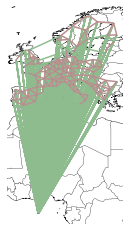

In [57]:
if __name__ == "__main__":
    if 'snakemake' not in globals():
        from helper import mock_snakemake
        print(os.getcwd())
        os.chdir("scripts")
        print(os.getcwd())
        snakemake = mock_snakemake(
            'plot_network',
            simpl='',
            clusters="128",
            scal="Tango",
            lv=1.0,
            opts='',
            sector_opts='3H-T-H-B-I-A',
            planning_horizons="2050",
        )
        os.chdir("../")
        
        
map_opts = snakemake.config['plotting']['map']
        
net.plot()

In [61]:
#net.iplot()

In [202]:
#df_c = getattr(net, "loads_t")
#df_c.p_set
#df_c.p
ntest=net
ntest.buses.drop(ntest.buses.index[ntest.buses.carrier != "AC"], inplace=True)
df_c = getattr(net, "loads_t")
df_c.p[[c for c in df_c.p.columns if "DE1 0" in c]]

demand_sizes = pd.Series(index = ntest.buses.index,dtype="float64")
for i in demand_sizes.index:
    demand_sizes[i] = df_c.p[[c for c in df_c.p.columns if i in c]].multiply(ntest.snapshot_weightings["objective"],axis=0).sum().sum()
    
    
demand_sizes/1e6
#df_c.p[[c for c in df_c.p.columns if "DE1 0" in c]]
#bus_sizes=demand_sizes

print('1')

#fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
#fig.set_size_inches(18, 15)
#ntest.plot(bus_sizes=demand_sizes/9e9,
#            line_widths=1e-4,#abs(ntest.lines_t.p0.loc[ntest.snapshots[3]]) / 2000,
#            link_widths=1e-4,#abs(ntest.links_t.p0.loc[ntest.snapshots[3]]) / 2000,
#            flow = "sum"#ntest.snapshots[:]
#          )

demand_sizes.sort_values()
#ntest.buses_t.marginal_price
net_exports = pd.DataFrame(index = ntest.snapshots,columns = ntest.buses.index,dtype="float64")
for b in net_exports.columns:
    print(b)
    ln1=ntest.lines_t.p1[[i for i in ntest.lines.index if b in ntest.lines.loc[i]["bus1"]]].sum(axis=1)
    ln0=ntest.lines_t.p0[[i for i in ntest.lines.index if b in ntest.lines.loc[i]["bus0"]]].sum(axis=1)
    lk1=ntest.links_t.p1[[i for i in ntest.links.index if b in ntest.links.loc[i]["bus1"] and ntest.links.loc[i]["carrier"]=="DC"]].sum(axis=1)
    lk0=ntest.links_t.p0[[i for i in ntest.links.index if b in ntest.links.loc[i]["bus0"] and ntest.links.loc[i]["carrier"]=="DC"]].sum(axis=1)
    net_exports[b] = ln1+ln0+lk1+lk0
    
    #ntest.lines.loc[[i for i in ntest.lines.index if "DE1 0" in ntest.lines.loc[i]["bus1"]]]

In [206]:
tot_exports = net_exports.sum()
tot_exports_color = pd.Series(index = tot_exports.index)
for i in tot_exports_color.index:
    if tot_exports.loc[i] < 0:
        tot_exports_color[i] = 'b'
    else:
        tot_exports_color[i] = 'r'

/tmp/ipykernel_27535/2903097078.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tot_exports_color = pd.Series(index = tot_exports.index)


(<matplotlib.collections.PatchCollection at 0x7f46b4668160>,
 <matplotlib.collections.PatchCollection at 0x7f46ba754520>)

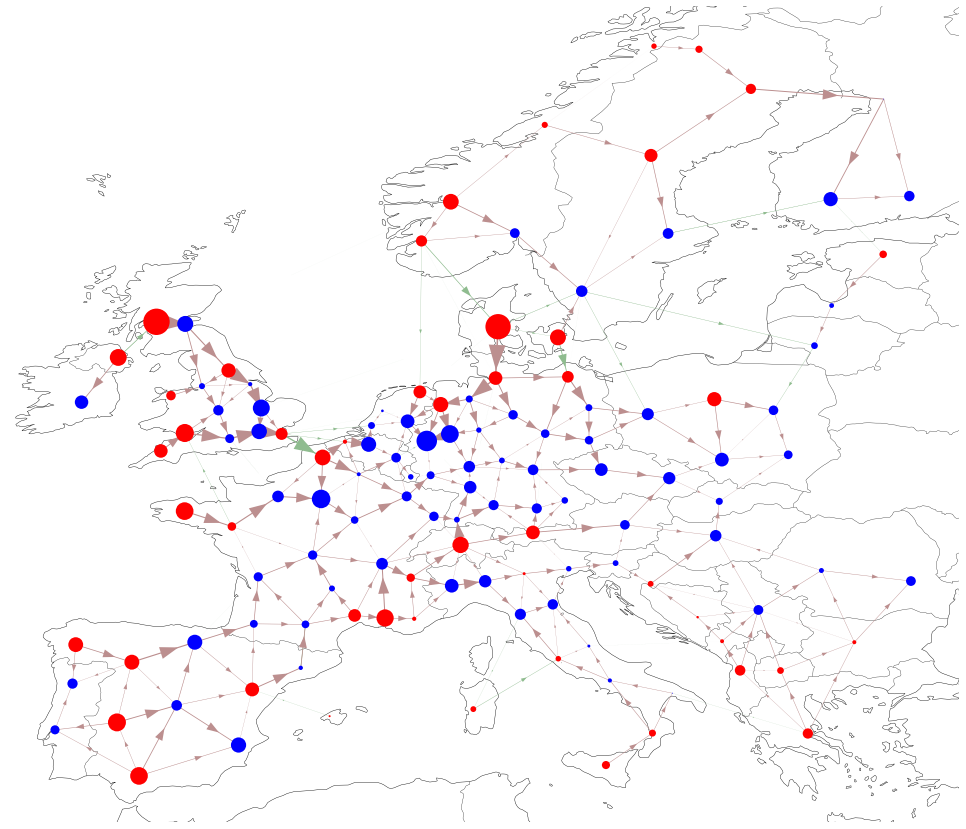

In [212]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(18, 15)
ntest.plot(bus_sizes=abs(tot_exports)/1e8,
            line_widths=1e-4,#abs(ntest.lines_t.p0.loc[ntest.snapshots[3]]) / 2000,
            link_widths=1e-4,#abs(ntest.links_t.p0.loc[ntest.snapshots[3]]) / 2000,
            bus_colors = tot_exports_color,
            flow = "sum"#ntest.snapshots[:]
          )

In [135]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='folder_with_images'
fps=1

image_files = [os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('my_video.mp4')

ModuleNotFoundError: No module named 'moviepy'